## Importing Libraries

In [ ]:
!python -m pip install transformers
!python -m pip install Sastrawi
!python -m pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
from Sastrawi.StopWordRemover.StopWordRemover import StopWordRemover
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

plt.style.use('ggplot')
np.__version__

'1.22.4'

## Loading the data

In [ ]:
!gdown 1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
!gdown 1b8WJZbxf48bJj7eAa-Z5MeWAqIq-SfU0

Downloading...
From: https://drive.google.com/uc?id=1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
To: /content/Symptom2DiseaseID.csv
100% 240k/240k [00:00<00:00, 68.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b8WJZbxf48bJj7eAa-Z5MeWAqIq-SfU0
To: /content/Dataset DS Converted.csv
100% 1.95M/1.95M [00:00<00:00, 131MB/s]


In [ ]:
dfNLP = pd.read_csv('./Symptom2DiseaseID.csv', delimiter=';')
dfNLP.drop("indeks", axis=1, inplace=True)
dfNLP.head()

,label,text
0,Psoriasis,"Saya telah mengalami ruam kulit di lengan, ka..."
1,Psoriasis,"Kulit saya mengelupas, terutama di lutut, sik..."
2,Psoriasis,"Saya telah mengalami nyeri sendi di jari, per..."
3,Psoriasis,"Ada debu seperti perak di kulit saya, terutam..."
4,Psoriasis,Kuku saya memiliki penyok atau lubang kecil d...


In [ ]:
dfCnv = pd.read_csv('./Dataset DS Converted.csv', delimiter=',')
dfCnv.drop("Unnamed: 0", axis=1, inplace=True)
dfCnv.head()

,symptoms,prognosa
0,Saya tidak merasakan penambahan berat badan. S...,0
1,Saya mengalami patch diskromik dalam beberapa ...,0
2,Saya tidak merasakan batuk. Sering bermasalah ...,0
3,"Sesekali, ruam kulit saya rasakan. Tidak ada k...",0
4,Saya tidak merasakan adanya demam ringan. Saya...,0


In [ ]:
dfNLP.label = dfNLP.label.str.replace('^ +| +$', '', regex=True)
dfNLP['label'] = dfNLP['label'].replace({'Pembuluh mekar':'Varises', 'Wasir Dimorfik' : 'Wasir', 'spondylosis serviks':'Spondylosis'})
dfCnv.rename(columns={'symptoms': 'text', 'prognosa': 'label'}, inplace=True)
dfCnv = dfCnv[dfCnv.columns[::-1]]

In [ ]:
indextolabel = {
    0: 'Vertigo Posisi Paroymsal',
    1: 'AIDS',
    2: 'Alergi',
    3: 'Asma bronkial',
    4: 'Cacar air',
    5: 'Diabetes',
    6: 'Flu biasa',
    7: 'GERD',
    8: 'Gastroenteritis',
    9: 'Hepatitis B',
    10: 'Hepatitis C',
    11: 'Hepatitis D',
    12: 'Hepatitis E',
    13: 'Hepatitis alkoholik',
    14: 'Hipertensi',
    15: 'Hipertiroidisme',
    16: 'Hipoglikemia',
    17: 'Hipotiroidisme',
    18: 'Impetigo',
    19: 'Infeksi jamur',
    20: 'Infeksi saluran kemih',
    21: 'Jerawat',
    22: 'Pendarahan Otak',
    23: 'Malaria',
    24: 'Migrain',
    25: 'Osteoartritis',
    26: 'Varises',
    27: 'Penyakit kuning',
    28: 'Penyakit tipus',
    29: 'Penyakit ulkus peptikum',
    30: 'Psoriasis',
    31: 'Radang paru-paru',
    32: 'Radang sendi',
    33: 'Reaksi Obat',
    34: 'Serangan jantung',
    35: 'TBC',
    36: 'Wasir',
    37: 'demam berdarah',
    38: 'hepatitis A',
    39: 'kolestasis kronis',
    40: 'Spondylosis',
}

dfCnv['label'] = dfCnv['label'].replace(indextolabel)

In [ ]:
dfNLP['label'].value_counts()

Psoriasis                          50
Varises                            50
penyakit ulkus peptikum            50
reaksi obat                        50
penyakit refluks gastroesofagus    50
alergi                             50
Infeksi saluran kemih              50
Malaria                            50
Penyakit kuning                    50
Spondylosis                        50
Migrain                            50
Hipertensi                         50
Asma bronkial                      50
Jerawat                            50
Radang sendi                       50
Wasir                              50
Radang paru-paru                   50
Flu biasa                          50
Infeksi jamur                      50
demam berdarah                     50
Impetigo                           50
Cacar air                          50
Penyakit tipus                     50
diabetes                           50
Name: label, dtype: int64

In [ ]:
dfCnv['label'].value_counts()

Vertigo Posisi Paroymsal    120
Jerawat                     120
Malaria                     120
Migrain                     120
Osteoartritis               120
Varises                     120
Penyakit kuning             120
Penyakit tipus              120
Penyakit ulkus peptikum     120
Psoriasis                   120
Radang paru-paru            120
Radang sendi                120
Reaksi Obat                 120
Serangan jantung            120
TBC                         120
Wasir                       120
demam berdarah              120
hepatitis A                 120
kolestasis kronis           120
Pendarahan Otak             120
Infeksi saluran kemih       120
AIDS                        120
Infeksi jamur               120
Alergi                      120
Asma bronkial               120
Cacar air                   120
Diabetes                    120
Flu biasa                   120
GERD                        120
Gastroenteritis             120
Hepatitis B                 120
Hepatiti

In [ ]:
dfMerge = pd.concat([dfCnv, dfNLP], ignore_index=True)

In [ ]:
dfMerge.head()

,label,text
0,Vertigo Posisi Paroymsal,Saya tidak merasakan penambahan berat badan. S...
1,Vertigo Posisi Paroymsal,Saya mengalami patch diskromik dalam beberapa ...
2,Vertigo Posisi Paroymsal,Saya tidak merasakan batuk. Sering bermasalah ...
3,Vertigo Posisi Paroymsal,"Sesekali, ruam kulit saya rasakan. Tidak ada k..."
4,Vertigo Posisi Paroymsal,Saya tidak merasakan adanya demam ringan. Saya...


In [ ]:
for nama_kolom in dfMerge.columns:
  print(dfMerge[nama_kolom].value_counts(), "\n")

Malaria                            170
Varises                            170
Penyakit kuning                    170
Penyakit tipus                     170
Jerawat                            170
Infeksi saluran kemih              170
Infeksi jamur                      170
Impetigo                           170
Psoriasis                          170
Radang paru-paru                   170
Hipertensi                         170
Radang sendi                       170
Migrain                            170
Wasir                              170
demam berdarah                     170
Flu biasa                          170
Cacar air                          170
Asma bronkial                      170
Spondylosis                        170
Serangan jantung                   120
TBC                                120
Penyakit ulkus peptikum            120
hepatitis A                        120
kolestasis kronis                  120
Reaksi Obat                        120
Vertigo Posisi Paroymsal 

In [ ]:
import itertools
factory = StopWordRemoverFactory()

addStopwords = ['dengan', 'ia', 'bahwa', 'oleh', 'saya']
removeStopwords = ['namun', 'tidak', 'setelah', 'masih', 'dengan', "merasakan", "adanya", "ada"]

stopWords = factory.get_stop_words()+addStopwords

for removeStopword in removeStopwords:
    if removeStopword in stopWords:
        stopWords.remove(removeStopword)
    else:
        continue

dictionaryWord = ArrayDictionary(stopWords)
stopWordRemover = StopWordRemover(dictionaryWord)

for i in range(len(dfMerge["text"])):
    dfMerge["text"][i] = re.sub('  +', ' ', dfMerge["text"][i])
    dfMerge["text"][i] = re.sub(r'[^\x00-\x7f]','r', dfMerge["text"][i])
    dfMerge["text"][i] = dfMerge["text"][i].encode('ascii', 'ignore').decode('utf-8')
    dfMerge["text"][i] = ''.join(''.join(s)[:1] for _, s in itertools.groupby(dfMerge["text"][i]))
    dfMerge["text"][i] = dfMerge["text"][i].lower()
    dfMerge["text"][i] = stopWordRemover.remove(dfMerge["text"][i])
    dfMerge["label"][i] = dfMerge["label"][i].lower()
    dfMerge["label"][i] = dfMerge["label"][i].title()

dfMerge.label = dfMerge.label.str.replace('^ +| +$', '', regex=True)

In [ ]:
dfMerge.head()

,label,text
0,Vertigo Posisi Paroymsal,tidak merasakan penambahan berat badan. mengal...
1,Vertigo Posisi Paroymsal,mengalami patch diskromik beberapa hari terakh...
2,Vertigo Posisi Paroymsal,tidak merasakan batuk. sering bermasalah gatal...
3,Vertigo Posisi Paroymsal,"sesekali, ruam kulit rasakan. tidak ada keasam..."
4,Vertigo Posisi Paroymsal,tidak merasakan adanya demam ringan. tidak mer...


In [ ]:
# df_sampel = pd.concat([dfMerge[dfMerge['label'] == kelas].sample(n=50, random_state=42) for kelas in dfMerge['label'].unique() if kelas not in ['Pembuluh Mekar', 'Wasir Dimorfik', 'Penyakit Refluks Gastroesofagus']])
# dfMerge = pd.concat([dfMerge[dfMerge['label'].isin(['Pembuluh Mekar', 'Wasir Dimorfik', 'Penyakit Refluks Gastroesofagus'])], df_sampel])

In [ ]:
for nama_kolom in dfMerge.columns:
  print(dfMerge[nama_kolom].value_counts(), "\n")

Jerawat                            170
Hipertensi                         170
Penyakit Tipus                     170
Migrain                            170
Malaria                            170
Penyakit Ulkus Peptikum            170
Psoriasis                          170
Infeksi Saluran Kemih              170
Infeksi Jamur                      170
Impetigo                           170
Radang Paru-Paru                   170
Radang Sendi                       170
Reaksi Obat                        170
Varises                            170
Penyakit Kuning                    170
Wasir                              170
Demam Berdarah                     170
Spondylosis                        170
Flu Biasa                          170
Diabetes                           170
Cacar Air                          170
Asma Bronkial                      170
Alergi                             170
Tbc                                120
Hepatitis A                        120
Kolestasis Kronis        

Creating encodings for disease.

In [ ]:
int2label = {}

for i, disease in enumerate(dfMerge['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Vertigo Posisi Paroymsal',
  1: 'Aids',
  2: 'Alergi',
  3: 'Asma Bronkial',
  4: 'Cacar Air',
  5: 'Diabetes',
  6: 'Flu Biasa',
  7: 'Gerd',
  8: 'Gastroenteritis',
  9: 'Hepatitis B',
  10: 'Hepatitis C',
  11: 'Hepatitis D',
  12: 'Hepatitis E',
  13: 'Hepatitis Alkoholik',
  14: 'Hipertensi',
  15: 'Hipertiroidisme',
  16: 'Hipoglikemia',
  17: 'Hipotiroidisme',
  18: 'Impetigo',
  19: 'Infeksi Jamur',
  20: 'Infeksi Saluran Kemih',
  21: 'Jerawat',
  22: 'Pendarahan Otak',
  23: 'Malaria',
  24: 'Migrain',
  25: 'Osteoartritis',
  26: 'Varises',
  27: 'Penyakit Kuning',
  28: 'Penyakit Tipus',
  29: 'Penyakit Ulkus Peptikum',
  30: 'Psoriasis',
  31: 'Radang Paru-Paru',
  32: 'Radang Sendi',
  33: 'Reaksi Obat',
  34: 'Serangan Jantung',
  35: 'Tbc',
  36: 'Wasir',
  37: 'Demam Berdarah',
  38: 'Hepatitis A',
  39: 'Kolestasis Kronis',
  40: 'Spondylosis',
  41: 'Penyakit Refluks Gastroesofagus'},
 {'Vertigo Posisi Paroymsal': 0,
  'Aids': 1,
  'Alergi': 2,
  'Asma Bronkial

## Data Distribution

Text(0.5, 1.0, 'Jumlah Data untuk masing-masing penyakit')

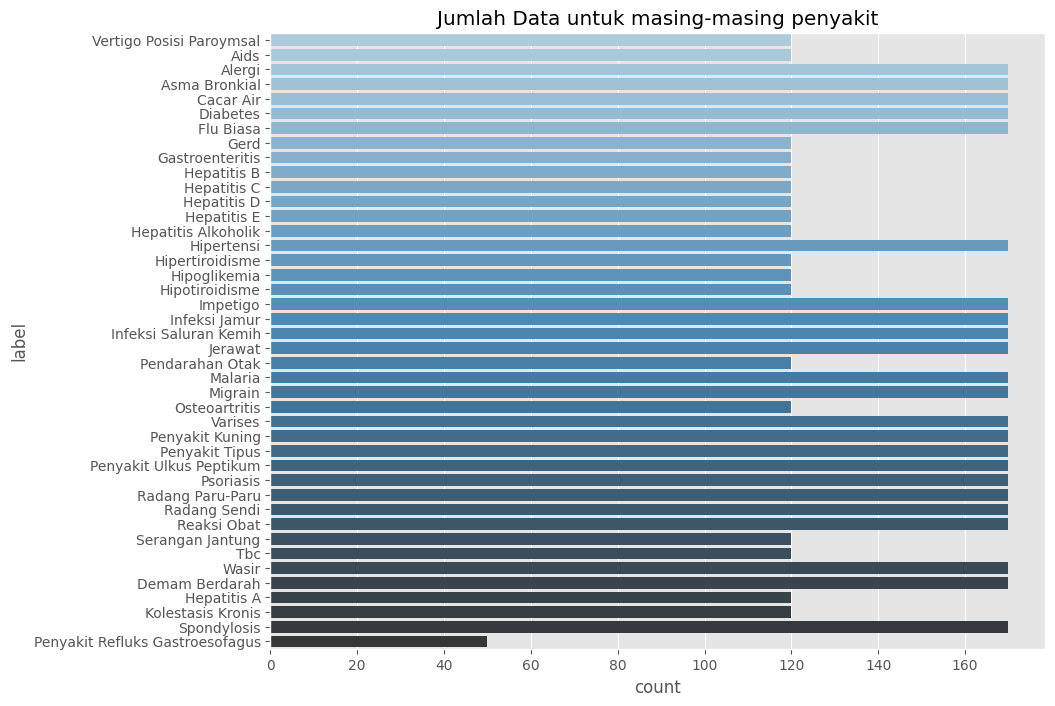

In [ ]:
plt.figure(figsize = (10, 8))

sea.countplot(y = dfMerge['label'], palette = 'Blues_d')
plt.title('Jumlah Data untuk masing-masing penyakit')

## Distribution of the lenght of description

  0%|          | 0/6120 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

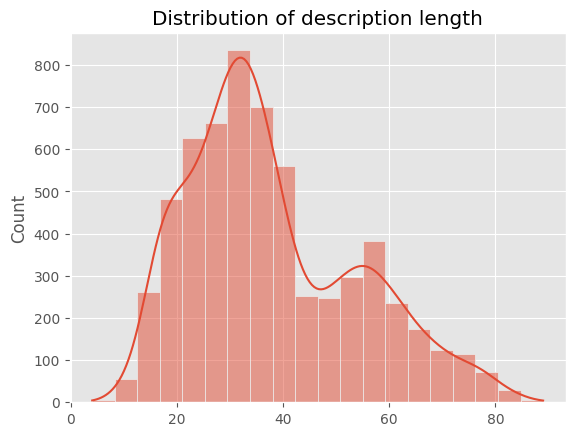

In [ ]:
# Masih perlu disesuaikan distribusi datanya, jangan ada yang kepanjangan

length = []
for txt in tqdm(dfMerge['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

In [ ]:
dfMerge['label'] = dfMerge['label'].map(lambda x : label2int[x])

In [ ]:
X, y = dfMerge['text'].values, dfMerge['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1834


## Creating the train and testing data

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((5508,), (612,), (5508,), (612,))

In [ ]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


In [ ]:
num_classes = 42

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7f26502622f0> True
<keras.layers.regularization.dropout.Dropout object at 0x7f26501dfdf0> True
<keras.layers.core.dense.Dense object at 0x7f2650008730> True


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  32298     
                                                                 
Total params: 177,885,738
Trainable params: 177,885,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 10
batch_size = 16

history = model.fit(train_dataset,
          batch_size=batch_size,
          epochs = EPOCHS,
          validation_data = val_dataset)

Epoch 1/10
689/689 [==============================] - 734s 992ms/step - loss: 2.1480 - accuracy: 0.5630 - val_loss: 0.4182 - val_accuracy: 0.9657
Epoch 2/10
689/689 [==============================] - 667s 967ms/step - loss: 0.2605 - accuracy: 0.9699 - val_loss: 0.0663 - val_accuracy: 0.9984
Epoch 3/10
689/689 [==============================] - 666s 966ms/step - loss: 0.0962 - accuracy: 0.9853 - val_loss: 0.0304 - val_accuracy: 0.9967
Epoch 4/10
689/689 [==============================] - 682s 990ms/step - loss: 0.0345 - accuracy: 0.9966 - val_loss: 0.0196 - val_accuracy: 0.9967
Epoch 5/10
689/689 [==============================] - 666s 967ms/step - loss: 0.0689 - accuracy: 0.9862 - val_loss: 0.0214 - val_accuracy: 0.9967
Epoch 6/10
689/689 [==============================] - 666s 966ms/step - loss: 0.0324 - accuracy: 0.9933 - val_loss: 0.0164 - val_accuracy: 0.9951
Epoch 7/10
689/689 [==============================] - 666s 967ms/step - loss: 0.0198 - accuracy: 0.9964 - val_loss: 0.0165 -

In [ ]:
model.evaluate(val_dataset, batch_size=batch_size)

77/77 [==============================] - 26s 334ms/step - loss: 0.0214 - accuracy: 0.9935


[0.021361080929636955, 0.9934640526771545]

## Plotting the loss and accuracy plot.

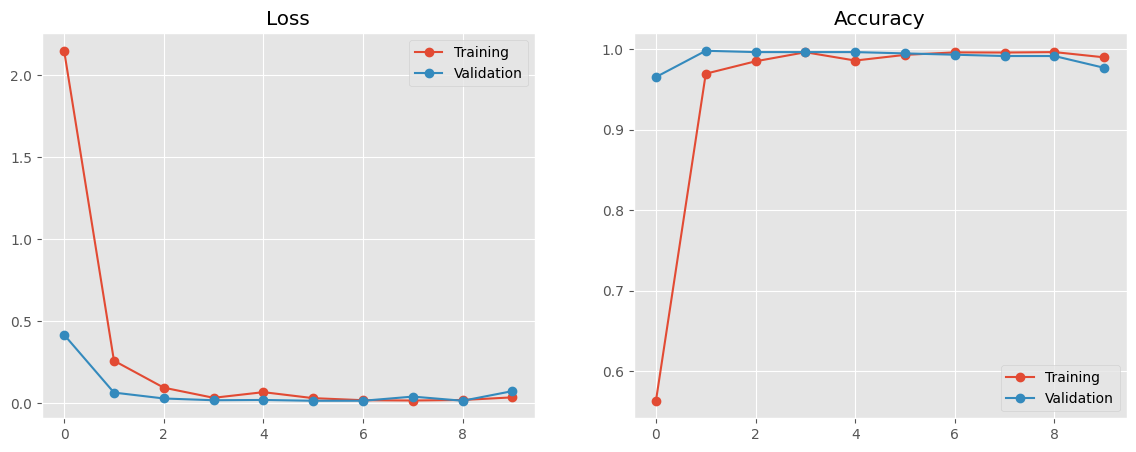

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

## Testing the model on custom input.

In [ ]:
path = "./model_merge_bert_multilungual_v4-2"
path2 = "./tokenizer_merge_bert_multilungual_v4-2"
model.save_pretrained(path)
tokenizer.save_pretrained(path2)

('./tokenizer_merge_bert_multilungual_v4-2/tokenizer_config.json',
 './tokenizer_merge_bert_multilungual_v4-2/special_tokens_map.json',
 './tokenizer_merge_bert_multilungual_v4-2/vocab.txt',
 './tokenizer_merge_bert_multilungual_v4-2/added_tokens.json',
 './tokenizer_merge_bert_multilungual_v4-2/tokenizer.json')

In [ ]:
!zip -r model_merge_bert_multilungual_v4-2.zip "/content/model_merge_bert_multilungual_v4-2"

  adding: content/model_merge_bert_multilungual_v4-2/ (stored 0%)
  adding: content/model_merge_bert_multilungual_v4-2/config.json (deflated 63%)
  adding: content/model_merge_bert_multilungual_v4-2/tf_model.h5 (deflated 7%)


In [ ]:
!zip -r tokenizer_merge_bert_multilungual_v4-2.zip "/content/tokenizer_merge_bert_multilungual_v4-2"

  adding: content/tokenizer_merge_bert_multilungual_v4-2/ (stored 0%)
  adding: content/tokenizer_merge_bert_multilungual_v4-2/tokenizer_config.json (deflated 42%)
  adding: content/tokenizer_merge_bert_multilungual_v4-2/special_tokens_map.json (deflated 42%)
  adding: content/tokenizer_merge_bert_multilungual_v4-2/vocab.txt (deflated 45%)
  adding: content/tokenizer_merge_bert_multilungual_v4-2/tokenizer.json (deflated 67%)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

In [ ]:
tokenizerlocal = BertTokenizer.from_pretrained("./tokenizer_merge_bert_multilungual_v4-2", local_files_only=True)

In [ ]:
modellocal = BertForSequenceClassification.from_pretrained("./model_merge_bert_multilungual_v4-2", from_tf=True)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=modellocal, tokenizer=tokenizerlocal, top_k = 24)

text1 = str(" Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing.").lower()
text2 = str("Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan.").lower()
text3 = str(" saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut.").lower()

pred1 = pipe(text1)
pred2 = pipe(text2)
pred3 = pipe(text3)

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.9963968396186829}, {'label': 'Migrain', 'score': 0.001066646771505475}]
[{'label': 'Penyakit Tipus', 'score': 0.9984679818153381}, {'label': 'Cacar Air', 'score': 0.00037161141517572105}]
[{'label': 'Penyakit Kuning', 'score': 0.9987961053848267}, {'label': 'Hepatitis B', 'score': 0.00024115685664582998}]


In [ ]:
factory = StopWordRemoverFactory()
addStopwords = ['dengan', 'ia', 'bahwa', 'oleh', 'saya']
removeStopwords = ['namun', 'tidak', 'setelah', 'masih', 'dengan', "merasakan", "adanya", "ada"]
stopWords = factory.get_stop_words()+addStopwords

for removeStopword in removeStopwords:
    if removeStopword in stopWords:
        stopWords.remove(removeStopword)
    else:
        continue

dictionaryWord = ArrayDictionary(stopWords)
stopWordRemover = StopWordRemover(dictionaryWord)

def preprocessing_user_input(text):
    global stopWordRemover

    text = re.sub('  +', ' ', text)
    text = re.sub(r'[^\x00-\x7f]','r', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))
    text = text.lower()
    text = stopWordRemover.remove(text)

    return text

In [ ]:
%%time
text1 = str(" Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing.").lower()
text2 = str("Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan.").lower()
text3 = str(" saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut.").lower()

pred1 = pipe(text1)
pred2 = pipe(text2)
pred3 = pipe(text3)

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.9963968396186829}, {'label': 'Migrain', 'score': 0.001066646771505475}]
[{'label': 'Penyakit Tipus', 'score': 0.9984679818153381}, {'label': 'Cacar Air', 'score': 0.00037161141517572105}]
[{'label': 'Penyakit Kuning', 'score': 0.9987961053848267}, {'label': 'Hepatitis B', 'score': 0.00024115685664582998}]
CPU times: user 784 ms, sys: 0 ns, total: 784 ms
Wall time: 812 ms


In [ ]:
%%time
text1 = " Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing."
text2 = "Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan."
text3 = " saya merasa sangat gatal, sakit, dan lelah. selain itu, berat badan saya turun dan suhu tubuh saya naik. urine saya berwarna gelap, dan kulit saya menjadi kuning. selain itu, saya juga mengalami sakit perut."

pred1 = pipe(preprocessing_user_input(text1))
pred2 = pipe(preprocessing_user_input(text2))
pred3 = pipe(preprocessing_user_input(text3))

print(pred1[0][:2])
print(pred2[0][:2])
print(pred3[0][:2])

[{'label': 'Diabetes', 'score': 0.9989564418792725}, {'label': 'Migrain', 'score': 0.00019830519158858806}]
[{'label': 'Penyakit Tipus', 'score': 0.9988058805465698}, {'label': 'Cacar Air', 'score': 0.00024589430540800095}]
[{'label': 'Penyakit Kuning', 'score': 0.9989773035049438}, {'label': 'Hepatitis B', 'score': 0.00020883929391857237}]
CPU times: user 698 ms, sys: 0 ns, total: 698 ms
Wall time: 722 ms


In [ ]:
!ls -lh tokenizer_merge_bert_multilungual_v4-2.zip model_merge_bert_multilungual_v4-2.zip

-rw-r--r-- 1 root root 630M Jun  3 20:48 model_merge_bert_multilungual_v4-2.zip
-rw-r--r-- 1 root root 1.5M Jun  3 20:48 tokenizer_merge_bert_multilungual_v4-2.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r tokenizer_merge_bert_multilungual_v4-2.zip "/content/drive/My Drive/Save Model Capstone/"

In [ ]:
!cp -r model_merge_bert_multilungual_v4-2.zip "/content/drive/My Drive/Save Model Capstone/"

In [ ]:
dfMerge.to_csv('data_merge_nlp-csv_clean_v4.csv', index = False, header = True, index_label = None)
!cp -r data_merge_nlp-csv_clean_v4.csv "/content/drive/My Drive/Save Model Capstone/"